In [2]:
%reload_ext autoreload
%autoreload 2

import os
import sys
import time
import cv2

from joblib import Parallel, delayed

sys.path.append(os.path.join(os.environ['REPO_DIR'], 'utilities'))
from utilities2015 import *

from matplotlib.path import Path
%matplotlib inline

import math
import random
import pickle
import copy

Setting environment for Gordon


In [3]:
labels = ['BackG', '5N', '7n', '7N', '12N', 'Pn', 'VLL', 
          '6N', 'Amb', 'R', 'Tz', 'RtTg', 'LRt', 'LC', 'AP', 'sp5']

n_class = len(labels)

In [4]:
class Hypersphere_abstain:
    
    def __init__(self, center, radius, threshold, label, alpha, beta, D, err, weighted_err, unweighted_err,
                 label_confidences, label_distribution, center_index, neighbor_indices, d_var, max_q_var):
        
        self.center = center
        self.radius = radius
        self.thres = threshold
        self.label = label
        self.alpha = alpha
        self.beta = beta
        self.D = D 
        self.pseudo_err = err # PSEUDO error
        self.weighted_err = weighted_err
        self.unweighted_err = unweighted_err
        self.label_confidences = label_confidences
        self.label_distribution = label_distribution
        self.center_index = center_index
        self.neighbor_indices = neighbor_indices
        
        # Hack
        self.d_var = d_var
        self.max_q_var = max_q_var
        
class WeakLearner_generator:
    
    def __init__(self, init_radius, growth_radius, end_radius, abstain_thres, err_thres):
        
        self.init_radius = init_radius
        self.growth_radius = growth_radius
        self.end_radius = end_radius
        self.abstain_thres = abstain_thres
        self.err_thres = err_thres
        
    def generate_pseudo(self, train_X, train_y, train_kernel, D, Q, mask, n_class):
        
        n_samples = train_X.shape[0]
        D = D.reshape((n_samples, ))

        # Choose an exemplar
        exemplar_index = np.random.choice(range(n_samples), p=D.tolist())
        exemplar = train_X[exemplar_index]

        # Retrieve scores to exemplar and sort
        scores = train_kernel[exemplar_index]
        sorted_scores = np.sort(scores)[::-1]
        sorted_indices = np.argsort(scores)[::-1]
        sorted_y = train_y[sorted_indices].astype('int64')
        sorted_D = D[sorted_indices]
        sorted_Q = Q[sorted_indices]
        sorted_mask = mask[sorted_indices]
        
        # Calculate plurarity and percentage of initial sphere
        init_size = np.argmax(sorted_scores<self.init_radius)
        count = np.bincount(sorted_y[:init_size],
                            weights=sorted_D[:init_size],
                            minlength=n_class)
        unweighted_count = np.bincount(sorted_y[:init_size],
                                       minlength=n_class)
        y_of_interest = np.argmax(count)
        percentage = count[y_of_interest]*1.0 / np.sum(sorted_D[:init_size])

        # Abstain test (HACK to avoid zero threshold)
        if np.sum(sorted_scores)==0.0:
            return None, None
        
        # Calculate cumulative weight sums
        sorted_D_tile = np.tile(sorted_D.reshape((n_samples,1)), (1, n_class))
        label_D_cum = np.cumsum(sorted_D_tile*sorted_mask, axis=0)
        label_Dq_cum = np.cumsum(sorted_D_tile*~sorted_mask*sorted_Q, axis=0)

        # Hypothesis and pseudo loss
#         radii = range(self.init_radius, n_samples, self.growth_radius)
#         radii = [self.init_radius*10]
#         radii = [n_samples]
        radii = np.arange(self.end_radius, self.init_radius+self.growth_radius, self.growth_radius)[::-1]
        hypo = np.zeros((len(radii), n_class), dtype=bool)
        pseudo_loss = np.zeros((len(radii),1))
        
        # For each radius
        for c,r in enumerate(radii):
            
            i = np.argmax(sorted_scores<r)
            
            # Calculate best hypotheses
            deriv = -1.0*label_D_cum[i-1]+label_Dq_cum[i-1]
            hypo[c] = (deriv<0.0).astype('float')
            label_conf = np.tile(hypo[c], (n_samples, 1))
#             print 'Sizes: ', hypo[c].shape, label_conf.shape
    
            # Calculate three terms in pseudo loss
            ones_term = np.ones((n_samples,1)).astype('float')
            label_term = np.sum(sorted_mask*label_conf, axis=1).reshape((n_samples,1)).astype('float')
            nonlabel_sum = np.sum(~sorted_mask*sorted_Q*label_conf, axis=1).reshape((n_samples,1)).astype('float')
            
            # Calculate pseudo loss
            pseudo_loss[c] = 0.5 * np.sum(sorted_D[:i].reshape((i,1))*(ones_term[:i] - label_term[:i] + nonlabel_sum[:i]))
            pseudo_loss[c] += 0.5 * np.sum(sorted_D[i:])
#             print '(Radius, Samples, P_loss): ', (r, i, pseudo_loss[c])
#             print 'sorted_D: ', sorted_D[:]
#             print 'Ones_term: ', ones_term[:]
#             print 'Label_term: ', label_term[:20]
#             print 'Nonlabel_term: ', nonlabel_sum[:20]
#             print 'Combined: ', (ones_term - label_term + nonlabel_sum)[:20]
#             print 'Calc: ', (sorted_D.reshape((n_samples,1))*(ones_term - label_term + nonlabel_sum))[:20]
#             print 'Sum: ', np.sum(sorted_D.reshape((n_samples,1))*(ones_term - label_term + nonlabel_sum))
            
            
        # Calculate best radius
        best_idx = np.argmin(pseudo_loss)
        best_radius = np.argmax(sorted_scores<radii[best_idx])
        
        # Prediction by best radius hypothesis
        label_conf = hypo[best_idx]
        p_err = pseudo_loss[best_idx]
#         print 'BEST RADIUS: ', best_radius
        
#         if random.random()<0.01:
#             print 'BEST (Size, Ploss, Hypo): ', (best_radius, list(p_err), list(label_conf.astype('int')))

        # Calculate label distritbution
        label_distribution = np.bincount(sorted_y[:best_radius], minlength=n_class)
    
        # Error test
        if p_err>self.err_thres:
            return None, None
        
        # Calculate alpha
        epsilon = 1.0e-24
        alpha = math.log((1.0-p_err+epsilon)/(p_err+epsilon))
        beta = (p_err+epsilon)*1.0/(1.0-p_err-epsilon)

        # Return weakleaner
        err = 0.0
        w_err = 0.0
        threshold = sorted_scores[best_radius-1]
        
        d_var = np.var(D)
        max_q_var= np.max(np.var(sorted_Q, axis=1))
        
        h = Hypersphere_abstain(exemplar, best_radius, threshold, y_of_interest,
                                alpha, beta, D, p_err, w_err, err, label_conf, label_distribution,
                                exemplar_index, sorted_indices, d_var, max_q_var)
        
        return h, sorted_mask
    

In [5]:
# Adaboost.M2

class Adaboost_M2:
    
    def __init__(self, iterations, n_class, weaklearner):
        
        self.T = iterations
        self.H = []
        self.D = None
        self.Q = None
        self.W = None
        self.W_staged = [] #Hack
        self.label_mask = None
        self.n_class = n_class
        self.weaklearner = weaklearner
    
    def train(self, train_X, train_y, train_kernel):
        
        n_samples = train_X.shape[0]
        
        # Create column mask for weights
        rows = list(xrange(n_samples))
        cols = train_y.astype('int64').tolist()
        self.label_mask = np.zeros((n_samples, self.n_class), dtype=bool)
        self.label_mask[rows, cols] = True
        
        # Initialize weights
        self.D = np.ones((n_samples, 1))*(1.0/n_samples)
        self.W = np.zeros((n_samples, self.n_class)) + \
                    ~self.label_mask*np.tile(self.D, (1,n_class))*(1.0/(self.n_class-1))
#         W_sum = np.sum(self.W, axis=1).reshape((n_samples,1))
#         self.Q = np.zeros((n_samples, self.n_class)) + \
#                     self.W*1.0/np.tile(W_sum,(1,self.n_class))
#         self.D = W_sum*1.0/np.sum(W_sum)

        for t in xrange(self.T):

            if t%1000==0:
                print 't: ', t
                
            # Normalize
            W_sum = np.sum(self.W, axis=1).reshape((n_samples,1))
            self.Q = np.zeros((n_samples, self.n_class)) + \
                        self.W*1.0/np.tile(W_sum,(1,self.n_class))
            self.D = W_sum*1.0/np.sum(W_sum)
#             print 'Sizes: ', (self.D.shape, self.Q.shape, self.W.shape, W_sum.shape)
#             print 'D_sum: ', np.sum(self.D)
#             print 'Q_sum: ', np.sum(self.Q*~self.label_mask, axis=1)
#             print 'Q_sum_sum: ', np.sum(np.sum(self.Q*~self.label_mask, axis=1))
#             print '~Q_sum: ', np.sum(np.sum(self.Q*self.label_mask, axis=1))
#             print 'W_sum==D? ', W_sum==self.D

#             Q_sample_sum = np.sum(self.Q, axis=1).reshape((n_samples, 1))
#             self.Q = self.Q / Q_sample_sum
#             self.D = Q_sample_sum / np.sum(Q_sample_sum)
#             print 'h: ', h.label_confidences.astype('int')
#             print 'Q: ', self.Q[:10,:]
#             print 'Q_sum: ', Q_sample_sum[:20]
            
            # Generate weaklearner
            h, h_neighbor_label_mask = \
                self.weaklearner.generate_pseudo(train_X, train_y, train_kernel, self.D, self.Q, self.label_mask, self.n_class)
            
            # Check abstained
            if not h:
                continue
                
            self.H.append(h)

            # Reweight
            base_term = h.beta*np.ones((n_samples, self.n_class))
            ones_term = np.ones((n_samples, self.n_class)).astype('float')
            label_weights = np.tile(h.label_confidences.reshape((1, self.n_class)), (n_samples, 1))
            label_term = np.sum(h_neighbor_label_mask*label_weights, axis=1).reshape((n_samples, 1))
            label_term = np.tile(label_term, ((1, self.n_class))).astype('float')
            nonlabel_term = ~h_neighbor_label_mask*label_weights.astype('float')
            
            power_term = 0.5*(ones_term + label_term - nonlabel_term)
            
            neighbors_in_sphere = h.neighbor_indices[:h.radius]
            neighbors_out_sphere = h.neighbor_indices[h.radius:]
#             self.Q[neighbors_in_sphere] = self.Q[neighbors_in_sphere] * \
#                                             np.power(base_term[:h.radius], power_term[:h.radius])
#             self.Q[neighbors_out_sphere] = self.Q[neighbors_out_sphere] * \
#                                             np.power(base_term[h.radius:], 0.5*ones_term[h.radius:])


            prev_W = copy.deepcopy(self.W)
    
#             print 'W[neighbors_in_sphere]: ', self.W[neighbors_in_sphere]
#             print 'W[neighbors_out_sphere]: ', self.W[neighbors_out_sphere]
    
            self.W[neighbors_in_sphere] = self.W[neighbors_in_sphere] * \
                                            np.power(base_term[:h.radius], power_term[:h.radius])
            self.W[neighbors_out_sphere] = self.W[neighbors_out_sphere] * \
                                            np.power(base_term[h.radius:], 0.5*ones_term[h.radius:])
        
#             print 'W_shape: ', self.W.shape
#             print 'neighbors_in_sphere: ', neighbors_in_sphere
#             print 'W[neighbors_in_sphere]: ', self.W[neighbors_in_sphere]
#             print 'W[neighbors_in_sphere].shape: ', self.W[neighbors_in_sphere].shape
#             print 'neighbors_out_sphere: ', neighbors_out_sphere
#             print 'W[neighbors_out_sphere]: ', self.W[neighbors_out_sphere]
#             print 'W[neighbors_out_sphere].shape: ', self.W[neighbors_out_sphere].shape
#             print 'Base_term: ', base_term
            
#             print 'Beta: ', h.beta
            
#             print 'h_label_mask: ', h_neighbor_label_mask
#             print 'h_label_mask.shape: ', h_neighbor_label_mask.shape
#             print 'h_label_mask==True: ', np.sum(np.sum(h_neighbor_label_mask==True))
#             print 'Label_weights: ', label_weights
#             print 'Label_term: '#, label_term
#             for sample in label_term:
#                 print '\t', sample[:]
#             print 'Nonlabel_term: '#, nonlabel_term
#             for sample in nonlabel_term:
#                 print '\t', sample[:]
#             print 'Power_term: '#, power_term
#             for sample in power_term:
#                 print '\t', sample[:]
#             print 'Neighbor Factor: '#, np.power(base_term[:h.radius], power_term[:h.radius])
#             for sample in np.power(base_term[:h.radius], power_term[:h.radius]):
#                 print '\t', sample[:] 
#             print 'Non-Neighbor Factor: '#, np.power(base_term[:h.radius], power_term[:h.radius])
#             for sample in np.power(base_term[h.radius:], 0.5*ones_term[h.radius:]):
#                 print '\t', sample[:]
            
#             print 'Diff: ', np.sum(np.sum(self.W*1.0-prev_W*1.0))
            self.W_staged.append(self.W)
            
#         print 'Q_sum: \n', Q_sample_sum[:20]
        print 'Num classifiers: ', len(self.H)

    def predict(self, train_X, train_y, train_kernel=None):

        no_kernel = train_kernel==None
        n_samples = train_X.shape[0]
        cumulative_prob = np.zeros((n_samples, self.n_class)).astype('float')
        staged_pred_y = np.zeros((len(self.H), n_samples)).astype('int64')
#         print 'n: ', n_samples
        
        if no_kernel:
            
            def compute_intersection_kernel_oneJob(i):
                dist = np.minimum(self.H[i].center, test_X)
                dist = np.sum(dist, axis=1).reshape((1, n_samples))
                return dist
            
            score_kernel = np.concatenate([compute_intersection_kernel_oneJob(i) for i in xrange(len(self.H))], axis=0)
            print 'Test kernel shape: ', score_kernel.shape
            
        else:
            score_kernel = None

        for i in xrange(len(self.H)):
            
            clf = self.H[i]
            
            score = np.copy(score_kernel[i]) if no_kernel else np.copy(train_kernel[clf.center_index])
            score[score < clf.thres] = 0.0 #Abstain
            score[score >= clf.thres] = math.log(1.0/clf.beta)
            
            label_weights = clf.label_confidences.astype('float')
            cumulative_prob += np.multiply(score.reshape((n_samples,1)), label_weights.reshape((1,self.n_class)))
            
#             print 'Radius: ', clf.radius
#             print 'Threshold: ', clf.thres
#             print 'Hypo: ', clf.label_confidences
#             print 'Score Vector: ', score
#             print 'CUR_SCORES: ', np.multiply(score.reshape((n_samples,1)), label_weights.reshape((1,self.n_class)))
            
#             if i%50==0:
#                 print i, clf.radius,
#                 print 'Threshold: ', clf.thres
#                 print 'Abstained: ', np.sum(score==0.0),
#                 print 'Score==0: ', np.sum(np.sum(np.multiply(score.reshape((n_samples,1)), label_weights.reshape((1,self.n_class))), axis=1)==0),
#                 print 'Beta: ', clf.beta,
#                 print 'Label: ', clf.label
#                 print 'Hypo: ', clf.label_confidences.astype('int')
#                 print 'Cumulative: \n', cumulative_prob[:5,:5]
                
            max_prob = np.max(cumulative_prob, axis=1)
            pred_y = np.argmax(cumulative_prob, axis=1)
            pred_y[max_prob==0.0] = 0
            staged_pred_y[i,:] = pred_y
        
        print 'Correct predictions: ', np.sum(train_y==staged_pred_y[-1])
        
        return staged_pred_y


In [ ]:
exprmt = 10
level = 'level0'
adaboost = [None for e in xrange(exprmt)]

for e in xrange(exprmt):
    
    print '\nExperiment #%d' %e
    
    tim = time.time()

    # Load preprocessed data
    train_X = bp.unpack_ndarray_file('sift-jpeg/preprocessed/train_%s_e%d_data.bp'%(level,e))
    train_y = bp.unpack_ndarray_file('sift-jpeg/preprocessed/train_%s_e%d_labels.bp'%(level,e))
    train_kernel = bp.unpack_ndarray_file('sift-jpeg/preprocessed/train_%s_e%d_spm_dist_mat.bp'%(level,e))
    train_fnames = bp.unpack_ndarray_file('sift-jpeg/preprocessed/train_%s_e%d_fnames.bp'%(level,e))

    test_X = bp.unpack_ndarray_file('sift-jpeg/preprocessed/test_%s_e%d_data.bp'%(level,e))
    test_y = bp.unpack_ndarray_file('sift-jpeg/preprocessed/test_%s_e%d_labels.bp'%(level,e))
    test_fnames = bp.unpack_ndarray_file('sift-jpeg/preprocessed/test_%s_e%d_fnames.bp'%(level,e))
    
    print train_X.shape
    print train_kernel.shape
    print test_X.shape
    
    # Setup
    weak = WeakLearner_generator(init_radius=0.5,
                                 growth_radius=0.05,
                                 end_radius=0.1,
                                 abstain_thres=0.5,
                                 err_thres=1.0)
    ada = Adaboost_M2(iterations=10000, 
                      n_class=n_class, 
                      weaklearner=weak)
    
    # Train
    ada.train(train_X, train_y, train_kernel)
    
    # Predcit Train
    staged_pred_y = ada.predict(train_X, train_y, train_kernel)
    
    # Predict Test
    staged_pred_y_test = ada.predict(test_X, test_y)
    
    # Calculate accuracy
    train_acc=[]
    n_training = staged_pred_y.shape[1]
    t_training = len(staged_pred_y)
    test_acc=[]
    n_testing = staged_pred_y_test.shape[1]
    t_testing = len(staged_pred_y_test)
    for t in xrange(t_training):
        train_acc.append(np.sum(staged_pred_y[t]==train_y)*1.0/n_training)
        test_acc.append(np.sum(staged_pred_y_test[t]==test_y)*1.0/n_testing)
    print 'Training: ', n_training
    print 'Final Accuracy: ', train_acc[-1]
    print 'Testing: ', n_testing
    print 'Final Accuracy: ', test_acc[-1]
    
    n_clf = len(ada.H);
    plt.figure(figsize=(10,5));
    plt.title("Accuracy v.s. Number of classifier");
    plt.xlabel("Number of classifiers");
    plt.ylabel("Percentage");
    plt.ylim([0.0, 1.0]);
    plt.plot(range(1, len(train_acc) + 1), train_acc, label='Train, accuracy');
    plt.plot(range(1, len(test_acc) + 1), test_acc, label='Test, accuracy');
    plt.legend(loc='best', fancybox=True, framealpha=0.5, fontsize=10);
    
    adaboost[e] = (ada, staged_pred_y, staged_pred_y_test)
    print ''

    sys.stderr.write('Experiment #%d time: %f seconds\n' % (e, (time.time() - tim))) # ~ 2s / 12k training data


Experiment #0
(5969, 200)
(5969, 5969)
(1495, 200)
t:  0
t:  100
t:  200
t:  300
t:  400
t:  500
t:  600
t:  700
t:  800
t:  900
t:  1000
t:  1100
t:  1200
t:  1300
t:  1400
t:  1500
t:  1600
t:  1700
t:  1800
t:  1900
t:  2000
t:  2100
t:  2200
t:  2300
t:  2400
t:  2500
t:  2600
t:  2700
t:  2800
t:  2900
t:  3000
t:  3100
t:  3200
t:  3300
t:  3400
t:  3500
t:  3600
t:  3700
t:  3800
t:  3900
t:  4000
t:  4100
t:  4200
t:  4300
t:  4400
t:  4500
t:  4600
t:  4700
t:  4800
t:  4900
t:  5000
t:  5100
t:  5200
t:  5300
t:  5400
t:  5500
t:  5600
t:  5700
t:  5800
t:  5900
t:  6000
t:  6100
t:  6200
t:  6300
t:  6400
t:  6500
t:  6600
t:  6700
t:  6800
t:  6900
t:  7000
t:  7100
t:  7200
t:  7300
t:  7400
t:  7500
t:  7600
t:  7700
t:  7800
t:  7900
t:  8000
t:  8100
t:  8200
t:  8300
t:  8400
t:  8500
t:  8600
t:  8700
t:  8800
t:  8900
t:  9000
t:  9100
t:  9200
t:  9300
t:  9400
t:  9500
t:  9600
t:  9700
t:  9800
t:  9900
t:  10000
t:  10100
t:  10200
t:  10300
t:  10400
t:  10500


/oasis/projects/nsf/csd181/yuncong/virtualenv-1.9.1/yuncongve/lib/python2.7/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in double_scalars
/oasis/projects/nsf/csd181/yuncong/virtualenv-1.9.1/yuncongve/lib/python2.7/site-packages/ipykernel/__main__.py:132: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.


 17967
Correct predictions:  4980
Test kernel shape:  (17967, 1495)
Correct predictions:  839
Training:  5969
Final Accuracy:  0.834310604791
Testing:  1495
Final Accuracy:  0.561204013378


Experiment #1
(5969, 200)
(5969, 5969)
(1495, 200)
t:  0
t:  100
t:  200
t:  300
t:  400
t:  500
t:  600
t:  700
t:  800
t:  900
t:  1000
t:  1100
t:  1200
t:  1300
t:  1400
t:  1500
t:  1600
t:  1700
t:  1800
t:  1900
t:  2000
t:  2100
t:  2200
t:  2300
t:  2400
t:  2500
t:  2600
t:  2700
t:  2800
t:  2900
t:  3000
t:  3100
t:  3200
t:  3300
t:  3400
t:  3500
t:  3600
t:  3700
t:  3800
t:  3900
t:  4000
t:  4100
t:  4200
t:  4300
t:  4400
t:  4500
t:  4600
t:  4700
t:  4800
t:  4900
t:  5000
t:  5100
t:  5200
t:  5300
t:  5400
t:  5500
t:  5600
t:  5700
t:  5800
t:  5900
t:  6000
t:  6100
t:  6200
t:  6300
t:  6400
t:  6500
t:  6600
t:  6700
t:  6800
t:  6900
t:  7000
t:  7100
t:  7200
t:  7300
t:  7400
t:  7500
t:  7600
t:  7700
t:  7800
t:  7900
t:  8000
t:  8100
t:  8200
t:  8300
t:  8400
t:  8

Experiment #0 time: 648.909622 seconds
Experiment #1 time: 526.849423 seconds




Experiment #2
(5969, 200)
(5969, 5969)
(1495, 200)
t:  0
t:  100
t:  200
t:  300
t:  400
t:  500
t:  600
t:  700
t:  800
t:  900
t:  1000
t:  1100
t:  1200
t:  1300
t:  1400
t:  1500
t:  1600
t:  1700
t:  1800
t:  1900
t:  2000
t:  2100
t:  2200
t:  2300
t:  2400
t:  2500
t:  2600
t:  2700
t:  2800
t:  2900
t:  3000
t:  3100
t:  3200
t:  3300
t:  3400
t:  3500
t:  3600
t:  3700
t:  3800
t:  3900
t:  4000
t:  4100
t:  4200
t:  4300
t:  4400
t:  4500
t:  4600
t:  4700
t:  4800
t:  4900
t:  5000
t:  5100
t:  5200
t:  5300
t:  5400
t:  5500
t:  5600
t:  5700
t:  5800
t:  5900
t:  6000
t:  6100
t:  6200
t:  6300
t:  6400
t:  6500
t:  6600
t:  6700
t:  6800
t:  6900
t:  7000
t:  7100
t:  7200
t:  7300
t:  7400
t:  7500
t:  7600
t:  7700
t:  7800
t:  7900
t:  8000
t:  8100
t:  8200
t:  8300
t:  8400
t:  8500
t:  8600
t:  8700
t:  8800
t:  8900
t:  9000
t:  9100
t:  9200
t:  9300
t:  9400
t:  9500
t:  9600
t:  9700
t:  9800
t:  9900
t:  10000
t:  10100
t:  10200
t:  10300
t:  10400
t:  10500

Experiment #2 time: 532.600102 seconds
Experiment #3 time: 535.223444 seconds




Experiment #4
(5969, 200)
(5969, 5969)
(1495, 200)
t:  0
t:  100
t:  200
t:  300
t:  400
t:  500
t:  600
t:  700
t:  800
t:  900
t:  1000
t:  1100
t:  1200
t:  1300
t:  1400
t:  1500
t:  1600
t:  1700
t:  1800
t:  1900
t:  2000
t:  2100
t:  2200
t:  2300
t:  2400
t:  2500
t:  2600
t:  2700
t:  2800
t:  2900
t:  3000
t:  3100
t:  3200
t:  3300
t:  3400
t:  3500
t:  3600
t:  3700
t:  3800
t:  3900
t:  4000
t:  4100
t:  4200
t:  4300
t:  4400
t:  4500
t:  4600
t:  4700
t:  4800
t:  4900
t:  5000
t:  5100
t:  5200
t:  5300
t:  5400
t:  5500
t:  5600
t:  5700
t:  5800
t:  5900
t:  6000
t:  6100
t:  6200
t:  6300
t:  6400
t:  6500
t:  6600
t:  6700
t:  6800
t:  6900
t:  7000
t:  7100
t:  7200
t:  7300
t:  7400
t:  7500
t:  7600
t:  7700
t:  7800
t:  7900
t:  8000
t:  8100
t:  8200
t:  8300
t:  8400
t:  8500
t:  8600
t:  8700
t:  8800
t:  8900
t:  9000
t:  9100
t:  9200
t:  9300
t:  9400
t:  9500
t:  9600
t:  9700
t:  9800
t:  9900
t:  10000
t:  10100
t:  10200
t:  10300
t:  10400
t:  10500

Experiment #4 time: 544.969426 seconds
Experiment #5 time: 532.819307 seconds




Experiment #6
(5969, 200)
(5969, 5969)
(1495, 200)
t:  0
t:  100
t:  200
t:  300
t:  400
t:  500
t:  600
t:  700
t:  800
t:  900
t:  1000
t:  1100
t:  1200
t:  1300
t:  1400
t:  1500
t:  1600
t:  1700
t:  1800
t:  1900
t:  2000
t:  2100
t:  2200
t:  2300
t:  2400
t:  2500
t:  2600
t:  2700
t:  2800
t:  2900
t:  3000
t:  3100
t:  3200
t:  3300
t:  3400
t:  3500
t:  3600
t:  3700
t:  3800
t:  3900
t:  4000
t:  4100
t:  4200
t:  4300
t:  4400
t:  4500
t:  4600
t:  4700
t:  4800
t:  4900
t:  5000
t:  5100
t:  5200
t:  5300
t:  5400
t:  5500
t:  5600
t:  5700
t:  5800
t:  5900
t:  6000
t:  6100
t:  6200
t:  6300
t:  6400
t:  6500
t:  6600
t:  6700
t:  6800
t:  6900
t:  7000
t:  7100
t:  7200
t:  7300
t:  7400
t:  7500
t:  7600
t:  7700
t:  7800
t:  7900
t:  8000
t:  8100
t:  8200
t:  8300
t:  8400
t:  8500
t:  8600
t:  8700
t:  8800
t:  8900
t:  9000
t:  9100
t:  9200
t:  9300
t:  9400
t:  9500
t:  9600
t:  9700
t:  9800
t:  9900
t:  10000
t:  10100
t:  10200
t:  10300
t:  10400
t:  10500

Experiment #6 time: 526.986130 seconds
Experiment #7 time: 536.041237 seconds




Experiment #8
(5969, 200)
(5969, 5969)
(1495, 200)
t:  0
t:  100
t:  200
t:  300
t:  400
t:  500
t:  600
t:  700
t:  800
t:  900
t:  1000
t:  1100
t:  1200
t:  1300
t:  1400
t:  1500
t:  1600
t:  1700
t:  1800
t:  1900
t:  2000
t:  2100
t:  2200
t:  2300
t:  2400
t:  2500
t:  2600
t:  2700
t:  2800
t:  2900
t:  3000
t:  3100
t:  3200
t:  3300
t:  3400
t:  3500
t:  3600
t:  3700
t:  3800
t:  3900
t:  4000
t:  4100
t:  4200
t:  4300
t:  4400
t:  4500
t:  4600
t:  4700
t:  4800
t:  4900
t:  5000
t:  5100
t:  5200
t:  5300
t:  5400
t:  5500
t:  5600
t:  5700
t:  5800
t:  5900
t:  6000
t:  6100
t:  6200
t:  6300
t:  6400
t:  6500
t:  6600
t:  6700
t:  6800
t:  6900
t:  7000
t:  7100
t:  7200
t:  7300
t:  7400
t:  7500
t:  7600
t:  7700
t:  7800
t:  7900
t:  8000
t:  8100
t:  8200
t:  8300
t:  8400
t:  8500
t:  8600
t:  8700
t:  8800
t:  8900
t:  9000
t:  9100
t:  9200
t:  9300
t:  9400
t:  9500
t:  9600
t:  9700
t:  9800
t:  9900
t:  10000
t:  10100
t:  10200
t:  10300
t:  10400
t:  10500


Experiment #9
(5969, 200)
(5969, 5969)
(1495, 200)
t:  0
t:  1000
t:  2000
t:  3000
t:  4000
t:  5000
t:  6000
t:  7000
t:  8000
t:  9000
t:  10000
t:  11000
t:  12000
t:  13000
t:  14000
t:  15000
t:  16000
t:  17000
t:  18000
t:  19000
Num classifiers: 

/oasis/projects/nsf/csd181/yuncong/virtualenv-1.9.1/yuncongve/lib/python2.7/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in double_scalars
/oasis/projects/nsf/csd181/yuncong/virtualenv-1.9.1/yuncongve/lib/python2.7/site-packages/ipykernel/__main__.py:132: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.


 17836
Correct predictions:  4964
Test kernel shape:  (17836, 1495)
Correct predictions:  856
Training:  5969
Final Accuracy:  0.831630088792
Testing:  1495
Final Accuracy:  0.572575250836



Experiment #9 time: 641.267136 seconds


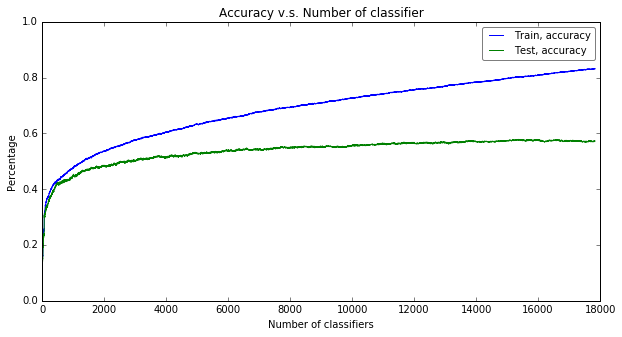

In [6]:
exprmt = 10
level = 'level0'
adaboost = [None for e in xrange(exprmt)]

for e in [9]:
    
    print '\nExperiment #%d' %e
    
    tim = time.time()

    # Load preprocessed data
    train_X = bp.unpack_ndarray_file('sift-jpeg/preprocessed/train_%s_e%d_data.bp'%(level,e))
    train_y = bp.unpack_ndarray_file('sift-jpeg/preprocessed/train_%s_e%d_labels.bp'%(level,e))
    train_kernel = bp.unpack_ndarray_file('sift-jpeg/preprocessed/train_%s_e%d_spm_dist_mat.bp'%(level,e))
    train_fnames = bp.unpack_ndarray_file('sift-jpeg/preprocessed/train_%s_e%d_fnames.bp'%(level,e))

    test_X = bp.unpack_ndarray_file('sift-jpeg/preprocessed/test_%s_e%d_data.bp'%(level,e))
    test_y = bp.unpack_ndarray_file('sift-jpeg/preprocessed/test_%s_e%d_labels.bp'%(level,e))
    test_fnames = bp.unpack_ndarray_file('sift-jpeg/preprocessed/test_%s_e%d_fnames.bp'%(level,e))
    
    print train_X.shape
    print train_kernel.shape
    print test_X.shape
    
    # Setup
    weak = WeakLearner_generator(init_radius=0.5,
                                 growth_radius=0.05,
                                 end_radius=0.2,
                                 abstain_thres=0.5,
                                 err_thres=1.0)
    ada = Adaboost_M2(iterations=20000, 
                      n_class=n_class, 
                      weaklearner=weak)
    
    # Train
    ada.train(train_X, train_y, train_kernel)
    
    # Predcit Train
    staged_pred_y = ada.predict(train_X, train_y, train_kernel)
    
    # Predict Test
    staged_pred_y_test = ada.predict(test_X, test_y)
    
    # Calculate accuracy
    train_acc=[]
    n_training = staged_pred_y.shape[1]
    t_training = len(staged_pred_y)
    test_acc=[]
    n_testing = staged_pred_y_test.shape[1]
    t_testing = len(staged_pred_y_test)
    for t in xrange(t_training):
        train_acc.append(np.sum(staged_pred_y[t]==train_y)*1.0/n_training)
        test_acc.append(np.sum(staged_pred_y_test[t]==test_y)*1.0/n_testing)
    print 'Training: ', n_training
    print 'Final Accuracy: ', train_acc[-1]
    print 'Testing: ', n_testing
    print 'Final Accuracy: ', test_acc[-1]
    
    n_clf = len(ada.H);
    plt.figure(figsize=(10,5));
    plt.title("Accuracy v.s. Number of classifier");
    plt.xlabel("Number of classifiers");
    plt.ylabel("Percentage");
    plt.ylim([0.0, 1.0]);
    plt.plot(range(1, len(train_acc) + 1), train_acc, label='Train, accuracy');
    plt.plot(range(1, len(test_acc) + 1), test_acc, label='Test, accuracy');
    plt.legend(loc='best', fancybox=True, framealpha=0.5, fontsize=10);
    
    adaboost[e] = (ada, staged_pred_y, staged_pred_y_test)
    print ''

    sys.stderr.write('Experiment #%d time: %f seconds\n' % (e, (time.time() - tim))) # ~ 2s / 12k training data

In [9]:
for (ada, y_train, y_test) in [adaboost[-1]]:
    for h in ada.H:
        print '(Radius, Thres): ', (h.radius, h.thres)

(Radius, Thres):  (2701, 0.40004782400765188)
(Radius, Thres):  (4154, 0.40013635999037456)
(Radius, Thres):  (2649, 0.45003117321304142)
(Radius, Thres):  (4014, 0.45004436557231586)
(Radius, Thres):  (1326, 0.20000000000000001)
(Radius, Thres):  (3862, 0.40003474786083482)
(Radius, Thres):  (4104, 0.40003538570417552)
(Radius, Thres):  (4283, 0.40001844678103671)
(Radius, Thres):  (3661, 0.44999999999999996)
(Radius, Thres):  (2741, 0.44999999999999996)
(Radius, Thres):  (3653, 0.450046685340803)
(Radius, Thres):  (5395, 0.25)
(Radius, Thres):  (2565, 0.40002777970692405)
(Radius, Thres):  (3112, 0.45002338998908464)
(Radius, Thres):  (5248, 0.30002024428099061)
(Radius, Thres):  (3709, 0.25)
(Radius, Thres):  (4364, 0.40001852580876729)
(Radius, Thres):  (2414, 0.45001576789656261)
(Radius, Thres):  (3852, 0.25)
(Radius, Thres):  (2129, 0.50006906486177161)
(Radius, Thres):  (2246, 0.5)
(Radius, Thres):  (3238, 0.4500145871827288)
(Radius, Thres):  (2523, 0.20000000000000001)
(Radiu


Experiment #9
(5969, 200)
(5969, 5969)
(1495, 200)
t:  0
t:  1000
t:  2000
t:  3000
t:  4000
t:  5000
t:  6000
t:  7000
t:  8000
t:  9000
t:  10000
t:  11000
t:  12000
t:  13000
t:  14000
t:  15000
t:  16000
t:  17000
t:  18000
t:  19000
Num classifiers: 

/oasis/projects/nsf/csd181/yuncong/virtualenv-1.9.1/yuncongve/lib/python2.7/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in double_scalars
/oasis/projects/nsf/csd181/yuncong/virtualenv-1.9.1/yuncongve/lib/python2.7/site-packages/ipykernel/__main__.py:132: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.


 17729
Correct predictions:  5042
Test kernel shape:  (17729, 1495)
Correct predictions:  888
Training:  5969
Final Accuracy:  0.844697604289
Testing:  1495
Final Accuracy:  0.59397993311



Experiment #9 time: 561.883739 seconds


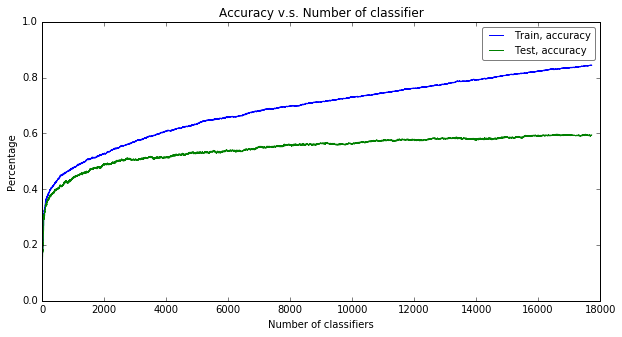

In [15]:
exprmt = 10
level = 'level0'
adaboost = [None for e in xrange(exprmt)]

for e in [9]:
    
    print '\nExperiment #%d' %e
    
    tim = time.time()

    # Load preprocessed data
    train_X = bp.unpack_ndarray_file('sift-jpeg/preprocessed/train_%s_e%d_data.bp'%(level,e))
    train_y = bp.unpack_ndarray_file('sift-jpeg/preprocessed/train_%s_e%d_labels.bp'%(level,e))
    train_kernel = bp.unpack_ndarray_file('sift-jpeg/preprocessed/train_%s_e%d_spm_dist_mat.bp'%(level,e))
    train_fnames = bp.unpack_ndarray_file('sift-jpeg/preprocessed/train_%s_e%d_fnames.bp'%(level,e))

    test_X = bp.unpack_ndarray_file('sift-jpeg/preprocessed/test_%s_e%d_data.bp'%(level,e))
    test_y = bp.unpack_ndarray_file('sift-jpeg/preprocessed/test_%s_e%d_labels.bp'%(level,e))
    test_fnames = bp.unpack_ndarray_file('sift-jpeg/preprocessed/test_%s_e%d_fnames.bp'%(level,e))
    
    print train_X.shape
    print train_kernel.shape
    print test_X.shape
    
    # Setup
    weak = WeakLearner_generator(init_radius=0.5,
                                 growth_radius=0.05,
                                 end_radius=0.1,
                                 abstain_thres=0.5,
                                 err_thres=1.0)
    ada = Adaboost_M2(iterations=20000, 
                      n_class=n_class, 
                      weaklearner=weak)
    
    # Train
    ada.train(train_X, train_y, train_kernel)
    
    # Predcit Train
    staged_pred_y = ada.predict(train_X, train_y, train_kernel)
    
    # Predict Test
    staged_pred_y_test = ada.predict(test_X, test_y)
    
    # Calculate accuracy
    train_acc=[]
    n_training = staged_pred_y.shape[1]
    t_training = len(staged_pred_y)
    test_acc=[]
    n_testing = staged_pred_y_test.shape[1]
    t_testing = len(staged_pred_y_test)
    for t in xrange(t_training):
        train_acc.append(np.sum(staged_pred_y[t]==train_y)*1.0/n_training)
        test_acc.append(np.sum(staged_pred_y_test[t]==test_y)*1.0/n_testing)
    print 'Training: ', n_training
    print 'Final Accuracy: ', train_acc[-1]
    print 'Testing: ', n_testing
    print 'Final Accuracy: ', test_acc[-1]
    
    n_clf = len(ada.H);
    plt.figure(figsize=(10,5));
    plt.title("Accuracy v.s. Number of classifier");
    plt.xlabel("Number of classifiers");
    plt.ylabel("Percentage");
    plt.ylim([0.0, 1.0]);
    plt.plot(range(1, len(train_acc) + 1), train_acc, label='Train, accuracy');
    plt.plot(range(1, len(test_acc) + 1), test_acc, label='Test, accuracy');
    plt.legend(loc='best', fancybox=True, framealpha=0.5, fontsize=10);
    
    adaboost[e] = (ada, staged_pred_y, staged_pred_y_test)
    print ''

    sys.stderr.write('Experiment #%d time: %f seconds\n' % (e, (time.time() - tim))) # ~ 2s / 12k training data

In [16]:
count = 0
for (ada, y_train, y_test) in [adaboost[-1]]:
    for h in ada.H:
        if h.thres<0.2:
            count += 1
            print '(Radius, Thres): ', (h.radius, h.thres)
print 'Percentage: ', count*1.0/len(ada.H)

(Radius, Thres):  (5700, 0.10211267605633803)
(Radius, Thres):  (234, 0.10000000000000001)
(Radius, Thres):  (5687, 0.10196078431372549)
(Radius, Thres):  (2980, 0.10000000000000001)
(Radius, Thres):  (5692, 0.10211267605633802)
(Radius, Thres):  (5724, 0.1020408163265306)
(Radius, Thres):  (5667, 0.10027855153203342)
(Radius, Thres):  (2487, 0.10000000000000001)
(Radius, Thres):  (5746, 0.1032258064516129)
(Radius, Thres):  (2779, 0.15000000000000002)
(Radius, Thres):  (5715, 0.10273972602739725)
(Radius, Thres):  (4993, 0.15018285896008907)
(Radius, Thres):  (131, 0.10000000000000001)
(Radius, Thres):  (5712, 0.1024390243902439)
(Radius, Thres):  (5071, 0.15017064846416384)
(Radius, Thres):  (5696, 0.10144927536231883)
(Radius, Thres):  (2814, 0.10000000000000001)
(Radius, Thres):  (5695, 0.10280373831775699)
(Radius, Thres):  (3271, 0.10000000000000001)
(Radius, Thres):  (3020, 0.15000000000000002)
(Radius, Thres):  (4989, 0.15000000000000002)
(Radius, Thres):  (5665, 0.100694444444


Experiment #0
(5969, 4200)
(5969, 5969)
(1495, 4200)
t:  0
t:  1000
t:  2000
t:  3000
t:  4000
t:  5000
t:  6000
t:  7000
t:  8000
t:  9000
Num classifiers: 

/oasis/projects/nsf/csd181/yuncong/virtualenv-1.9.1/yuncongve/lib/python2.7/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in double_scalars
/oasis/projects/nsf/csd181/yuncong/virtualenv-1.9.1/yuncongve/lib/python2.7/site-packages/ipykernel/__main__.py:132: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.


 9279
Correct predictions:  4247
Test kernel shape:  (9279, 1495)
Correct predictions:  805
Training:  5969
Final Accuracy:  0.711509465572
Testing:  1495
Final Accuracy:  0.538461538462


Experiment #1
(5969, 4200)
(5969, 5969)
(1495, 4200)
t:  0
t:  1000
t:  2000
t:  3000
t:  4000
t:  5000
t:  6000
t:  7000
t:  8000
t:  9000
Num classifiers:  9265
Correct predictions:  4245
Test kernel shape:  (9265, 1495)
Correct predictions:  861
Training:  5969
Final Accuracy:  0.711174401072
Testing:  1495
Final Accuracy:  0.575919732441


Experiment #0 time: 618.781572 seconds
Experiment #1 time: 653.506340 seconds




Experiment #2
(5969, 4200)
(5969, 5969)
(1495, 4200)
t:  0
t:  1000
t:  2000
t:  3000
t:  4000
t:  5000
t:  6000
t:  7000
t:  8000
t:  9000
Num classifiers:  9344
Correct predictions:  4255
Test kernel shape:  (9344, 1495)
Correct predictions:  820
Training:  5969
Final Accuracy:  0.712849723572
Testing:  1495
Final Accuracy:  0.548494983278


Experiment #3
(5969, 4200)
(5969, 5969)
(1495, 4200)
t:  0
t:  1000
t:  2000
t:  3000
t:  4000
t:  5000
t:  6000
t:  7000
t:  8000
t:  9000
Num classifiers:  9230
Correct predictions:  4258
Test kernel shape:  (9230, 1495)
Correct predictions:  872
Training:  5969
Final Accuracy:  0.713352320322
Testing:  1495
Final Accuracy:  0.583277591973


Experiment #2 time: 1536.000122 seconds
Experiment #3 time: 684.192817 seconds




Experiment #4
(5969, 4200)
(5969, 5969)
(1495, 4200)
t:  0
t:  1000
t:  2000
t:  3000
t:  4000
t:  5000
t:  6000
t:  7000
t:  8000
t:  9000
Num classifiers:  9230
Correct predictions:  4258
Test kernel shape:  (9230, 1495)
Correct predictions:  831
Training:  5969
Final Accuracy:  0.713352320322
Testing:  1495
Final Accuracy:  0.555852842809



Experiment #4 time: 612.007405 seconds


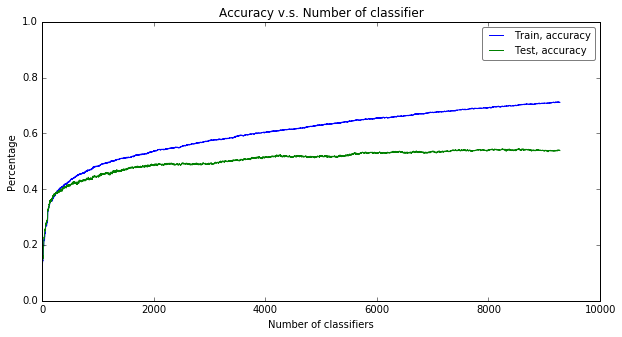

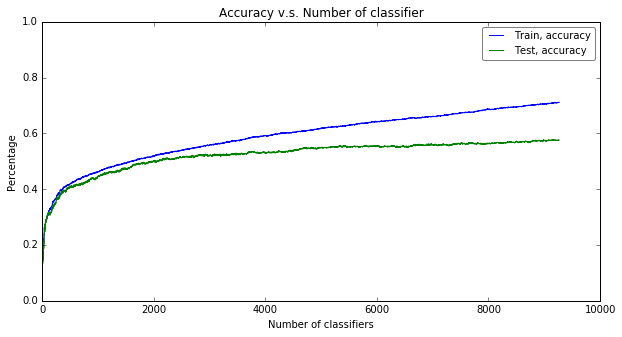

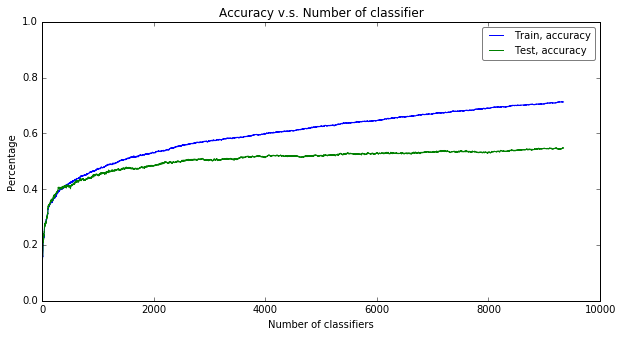

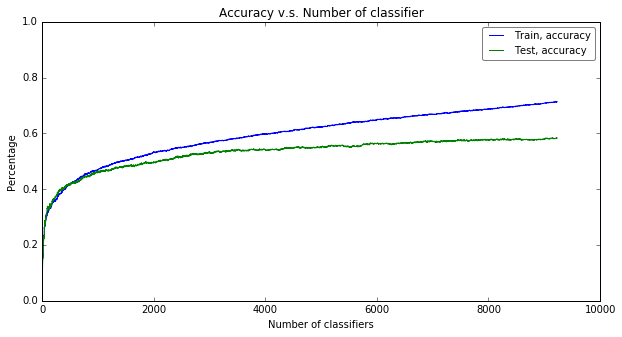

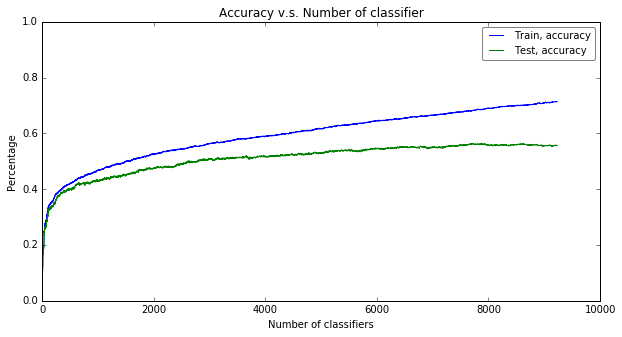

In [6]:
exprmt = 5
level = 'level2'
adaboost2 = [None for e in xrange(exprmt)]

for e in xrange(exprmt):
    
    print '\nExperiment #%d' %e
    
    tim = time.time()

    # Load preprocessed data
    train_X = bp.unpack_ndarray_file('sift-jpeg/preprocessed/train_%s_e%d_data.bp'%(level,e))
    train_y = bp.unpack_ndarray_file('sift-jpeg/preprocessed/train_%s_e%d_labels.bp'%(level,e))
    train_kernel = bp.unpack_ndarray_file('sift-jpeg/preprocessed/train_%s_e%d_spm_dist_mat.bp'%(level,e))
    train_fnames = bp.unpack_ndarray_file('sift-jpeg/preprocessed/train_%s_e%d_fnames.bp'%(level,e))

    test_X = bp.unpack_ndarray_file('sift-jpeg/preprocessed/test_%s_e%d_data.bp'%(level,e))
    test_y = bp.unpack_ndarray_file('sift-jpeg/preprocessed/test_%s_e%d_labels.bp'%(level,e))
    test_fnames = bp.unpack_ndarray_file('sift-jpeg/preprocessed/test_%s_e%d_fnames.bp'%(level,e))
    
    print train_X.shape
    print train_kernel.shape
    print test_X.shape
    
    # Setup
    weak = WeakLearner_generator(init_radius=0.5,
                                 growth_radius=0.05,
                                 end_radius=0.1,
                                 abstain_thres=0.5,
                                 err_thres=1.0)
    ada = Adaboost_M2(iterations=10000, 
                      n_class=n_class, 
                      weaklearner=weak)
    
    # Train
    ada.train(train_X, train_y, train_kernel)
    
    # Predcit Train
    staged_pred_y = ada.predict(train_X, train_y, train_kernel)
    
    # Predict Test
    staged_pred_y_test = ada.predict(test_X, test_y)
    
    # Calculate accuracy
    train_acc=[]
    n_training = staged_pred_y.shape[1]
    t_training = len(staged_pred_y)
    test_acc=[]
    n_testing = staged_pred_y_test.shape[1]
    t_testing = len(staged_pred_y_test)
    for t in xrange(t_training):
        train_acc.append(np.sum(staged_pred_y[t]==train_y)*1.0/n_training)
        test_acc.append(np.sum(staged_pred_y_test[t]==test_y)*1.0/n_testing)
    print 'Training: ', n_training
    print 'Final Accuracy: ', train_acc[-1]
    print 'Testing: ', n_testing
    print 'Final Accuracy: ', test_acc[-1]
    
    n_clf = len(ada.H);
    plt.figure(figsize=(10,5));
    plt.title("Accuracy v.s. Number of classifier");
    plt.xlabel("Number of classifiers");
    plt.ylabel("Percentage");
    plt.ylim([0.0, 1.0]);
    plt.plot(range(1, len(train_acc) + 1), train_acc, label='Train, accuracy');
    plt.plot(range(1, len(test_acc) + 1), test_acc, label='Test, accuracy');
    plt.legend(loc='best', fancybox=True, framealpha=0.5, fontsize=10);
    
    adaboost2[e] = (ada, staged_pred_y, staged_pred_y_test)
    print ''

    sys.stderr.write('Experiment #%d time: %f seconds\n' % (e, (time.time() - tim))) # ~ 2s / 12k training data


Experiment #0
(4476, 200)
(4476, 4476)
(2988, 200)
t:  0
t:  1000
t:  2000
t:  3000
t:  4000
t:  5000
t:  6000
t:  7000
t:  8000
t:  9000
Num classifiers: 

/oasis/projects/nsf/csd181/yuncong/virtualenv-1.9.1/yuncongve/lib/python2.7/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in double_scalars
/oasis/projects/nsf/csd181/yuncong/virtualenv-1.9.1/yuncongve/lib/python2.7/site-packages/ipykernel/__main__.py:132: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.


 9070
Correct predictions:  3349
Test kernel shape:  (9070, 2988)
Correct predictions:  1587
Training:  4476
Final Accuracy:  0.748212689902
Testing:  2988
Final Accuracy:  0.531124497992


Experiment #1
(4476, 200)
(4476, 4476)
(2988, 200)
t:  0
t:  1000
t:  2000
t:  3000
t:  4000
t:  5000
t:  6000
t:  7000
t:  8000
t:  9000
Num classifiers:  9097
Correct predictions:  3391
Test kernel shape:  (9097, 2988)
Correct predictions:  1629
Training:  4476
Final Accuracy:  0.757596067918
Testing:  2988
Final Accuracy:  0.545180722892


Experiment #0 time: 261.361657 seconds
Experiment #1 time: 256.006718 seconds




Experiment #2
(4476, 200)
(4476, 4476)
(2988, 200)
t:  0
t:  1000
t:  2000
t:  3000
t:  4000
t:  5000
t:  6000
t:  7000
t:  8000
t:  9000
Num classifiers:  9028
Correct predictions:  3352
Test kernel shape:  (9028, 2988)
Correct predictions:  1608
Training:  4476
Final Accuracy:  0.748882931189
Testing:  2988
Final Accuracy:  0.538152610442


Experiment #3
(4476, 200)
(4476, 4476)
(2988, 200)
t:  0
t:  1000
t:  2000
t:  3000
t:  4000
t:  5000
t:  6000
t:  7000
t:  8000
t:  9000
Num classifiers:  9040
Correct predictions:  3405
Test kernel shape:  (9040, 2988)
Correct predictions:  1631
Training:  4476
Final Accuracy:  0.76072386059
Testing:  2988
Final Accuracy:  0.545850066934


Experiment #2 time: 251.937574 seconds
Experiment #3 time: 246.618511 seconds




Experiment #4
(4476, 200)
(4476, 4476)
(2988, 200)
t:  0
t:  1000
t:  2000
t:  3000
t:  4000
t:  5000
t:  6000
t:  7000
t:  8000
t:  9000
Num classifiers:  9173
Correct predictions:  3428
Test kernel shape:  (9173, 2988)
Correct predictions:  1653
Training:  4476
Final Accuracy:  0.765862377122
Testing:  2988
Final Accuracy:  0.553212851406


Experiment #5
(4476, 200)
(4476, 4476)
(2988, 200)
t:  0
t:  1000
t:  2000
t:  3000
t:  4000
t:  5000
t:  6000
t:  7000
t:  8000
t:  9000
Num classifiers:  9017
Correct predictions:  3375
Test kernel shape:  (9017, 2988)
Correct predictions:  1595
Training:  4476
Final Accuracy:  0.754021447721
Testing:  2988
Final Accuracy:  0.533801874163


Experiment #4 time: 251.723279 seconds
Experiment #5 time: 243.649741 seconds




Experiment #6
(4476, 200)
(4476, 4476)
(2988, 200)
t:  0
t:  1000
t:  2000
t:  3000
t:  4000
t:  5000
t:  6000
t:  7000
t:  8000
t:  9000
Num classifiers:  9111
Correct predictions:  3426
Test kernel shape:  (9111, 2988)
Correct predictions:  1678
Training:  4476
Final Accuracy:  0.765415549598
Testing:  2988
Final Accuracy:  0.561579651941


Experiment #7
(4476, 200)
(4476, 4476)
(2988, 200)
t:  0
t:  1000
t:  2000
t:  3000
t:  4000
t:  5000
t:  6000
t:  7000
t:  8000
t:  9000
Num classifiers:  9051
Correct predictions:  3401


Experiment #6 time: 245.628483 seconds


MemoryError: 

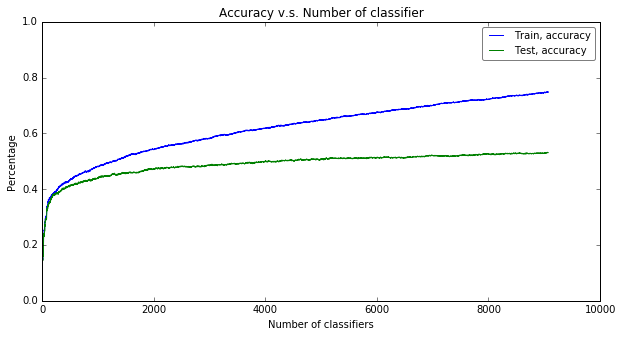

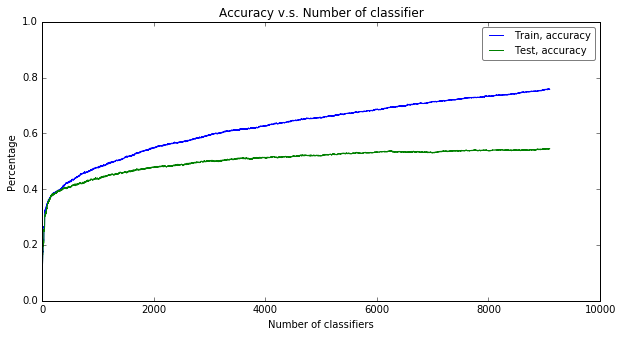

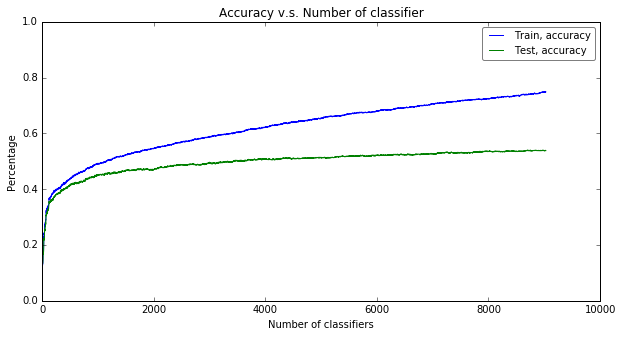

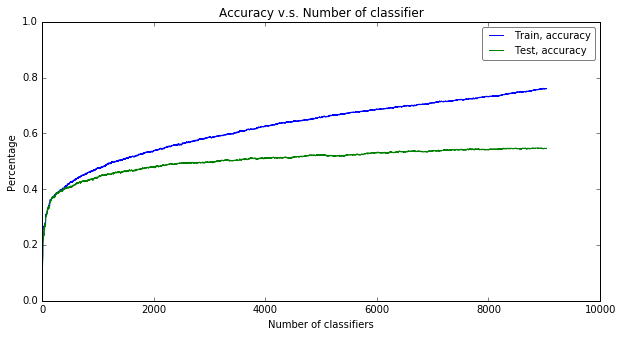

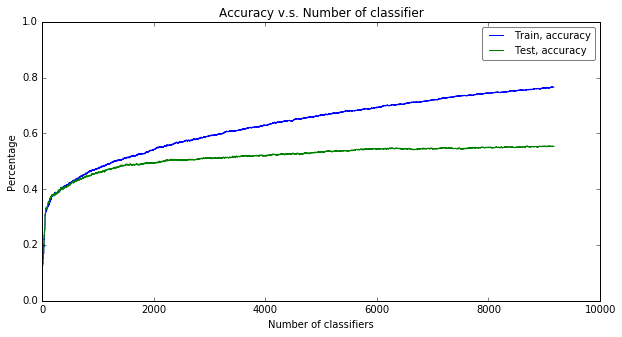

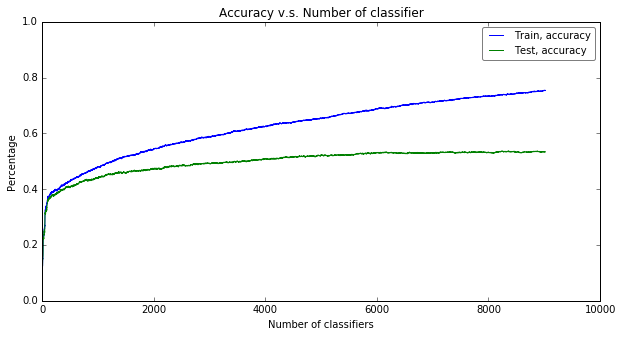

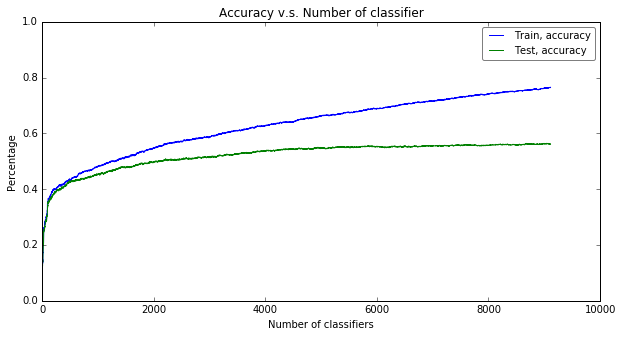

In [18]:
exprmt = 10
level = 'level0'
adaboost3 = [None for e in xrange(exprmt)]

for e in xrange(exprmt):
    
    print '\nExperiment #%d' %e
    
    tim = time.time()

    # Load preprocessed data
    train_X = bp.unpack_ndarray_file('sift-jpeg/preprocessed/train_%s_64_e%d_data.bp'%(level,e))
    train_y = bp.unpack_ndarray_file('sift-jpeg/preprocessed/train_%s_64_e%d_labels.bp'%(level,e))
    train_kernel = bp.unpack_ndarray_file('sift-jpeg/preprocessed/train_%s_64_e%d_spm_dist_mat.bp'%(level,e))
    train_fnames = bp.unpack_ndarray_file('sift-jpeg/preprocessed/train_%s_64_e%d_fnames.bp'%(level,e))

    test_X = bp.unpack_ndarray_file('sift-jpeg/preprocessed/test_%s_64_e%d_data.bp'%(level,e))
    test_y = bp.unpack_ndarray_file('sift-jpeg/preprocessed/test_%s_64_e%d_labels.bp'%(level,e))
    test_fnames = bp.unpack_ndarray_file('sift-jpeg/preprocessed/test_%s_64_e%d_fnames.bp'%(level,e))
    
    print train_X.shape
    print train_kernel.shape
    print test_X.shape
    
    # Setup
    weak = WeakLearner_generator(init_radius=0.5,
                                 growth_radius=0.05,
                                 end_radius=0.1,
                                 abstain_thres=0.5,
                                 err_thres=1.0)
    ada = Adaboost_M2(iterations=10000, 
                      n_class=n_class, 
                      weaklearner=weak)
    
    # Train
    ada.train(train_X, train_y, train_kernel)
    
    # Predcit Train
    staged_pred_y = ada.predict(train_X, train_y, train_kernel)
    
    # Predict Test
    staged_pred_y_test = ada.predict(test_X, test_y)
    
    # Calculate accuracy
    train_acc=[]
    n_training = staged_pred_y.shape[1]
    t_training = len(staged_pred_y)
    test_acc=[]
    n_testing = staged_pred_y_test.shape[1]
    t_testing = len(staged_pred_y_test)
    for t in xrange(t_training):
        train_acc.append(np.sum(staged_pred_y[t]==train_y)*1.0/n_training)
        test_acc.append(np.sum(staged_pred_y_test[t]==test_y)*1.0/n_testing)
    print 'Training: ', n_training
    print 'Final Accuracy: ', train_acc[-1]
    print 'Testing: ', n_testing
    print 'Final Accuracy: ', test_acc[-1]
    
    n_clf = len(ada.H);
    plt.figure(figsize=(10,5));
    plt.title("Accuracy v.s. Number of classifier");
    plt.xlabel("Number of classifiers");
    plt.ylabel("Percentage");
    plt.ylim([0.0, 1.0]);
    plt.plot(range(1, len(train_acc) + 1), train_acc, label='Train, accuracy');
    plt.plot(range(1, len(test_acc) + 1), test_acc, label='Test, accuracy');
    plt.legend(loc='best', fancybox=True, framealpha=0.5, fontsize=10);
    
    adaboost3[e] = (ada, staged_pred_y, staged_pred_y_test)
    print ''

    sys.stderr.write('Experiment #%d time: %f seconds\n' % (e, (time.time() - tim))) # ~ 2s / 12k training data